In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from utilities.data_processing import ProcessInput
%matplotlib inline

# Modelling LFC results

Attempt to build a model to predict the result of a liverpool game

### Load fixture history data

Currently only interested in the Premier League, so limit the data to that for now

In [2]:
file_path = os.path.join('data', 'liverpool_fixture_history.csv')
df = pd.read_csv(file_path)
df = df[df['competition'] == 'Premier League']
df.head(5)

,away_score,competition,date,home_score,nth_game_this_season,opposition,venue
64,0,Premier League,14/08/1993,2,1,Sheffield Wednesday,Anfield
65,1,Premier League,18/08/1993,3,2,Queens Park Rangers,Loftus Road
66,0,Premier League,22/08/1993,5,3,Swindon Town,County Ground
67,2,Premier League,25/08/1993,1,4,Tottenham Hotspur,Anfield
68,0,Premier League,28/08/1993,2,5,Leeds United,Anfield


## Feature extraction

Use predefined transformation method to add in additional features including:

- A scaled version of the date to act as a weight column, giving more weight to more recent games
- Extracting the day of week from the data column, as well as days since last game
- Drop the venue column after converting it to a home/away flag
- Add the current win streak and undefeated streaks as integers
- Create a beatability index for each oppositon based on previous performance against them

In [3]:
processor = ProcessInput()
df = processor.fit_transform(df)
df.head()

,competition,date,nth_game_this_season,opposition,liverpool_at_home,result,liverpool_goals_scored,opposition_goals_scored,win_flag,loss_flag,...,win_streak,undefeated_streak,pl_gameweek,PPG,season_number,season_points,GFPG,GAPG,GDPG,n_times_teams_played
0,Premier League,1.000000,33,24,True,1,4.0,3.0,True,False,...,0,0,0,1.454545,0,32,1.909091,1.500000,0.409091,38
1,Premier League,0.998542,31,10,False,2,1.0,2.0,False,True,...,2,3,22,1.523810,24,32,1.952381,1.476190,0.476190,8
2,Premier League,0.998318,30,23,True,1,2.0,1.0,True,False,...,1,2,21,1.450000,24,29,1.950000,1.500000,0.450000,22
3,Premier League,0.997870,29,39,True,1,5.0,0.0,True,False,...,0,1,20,1.368421,24,26,1.789474,1.578947,0.210526,13
4,Premier League,0.997421,28,0,False,0,3.0,3.0,False,False,...,0,0,19,1.388889,24,25,1.722222,1.500000,0.222222,48


### Average performance vs specific opposition

A beatability index gives an indication of how well Liverpool plays against each team in the premier league.

For any given opposition, it is simply:

\begin{align}
b_{opp} = \frac{games\ won_{opp}}{total\ games_{opp}} - \frac{games\ lost_{opp}}{total\ games_{opp}}
\end{align}



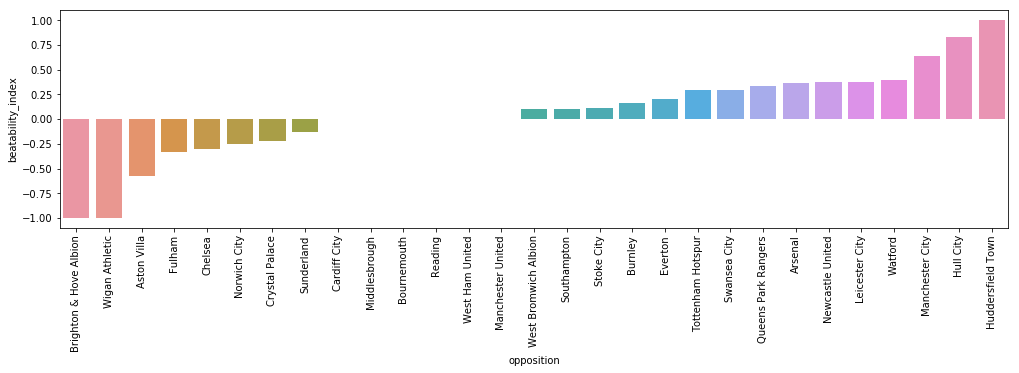

In [4]:
plt.figure(figsize=[17, 4])
barplot = sns.barplot(x='opposition', y='beatability_index', data=processor.beatability_df.sort_values(by='beatability_index'))
for label in barplot.get_xticklabels():
    label.set_rotation(90)

### Performance as season progresses

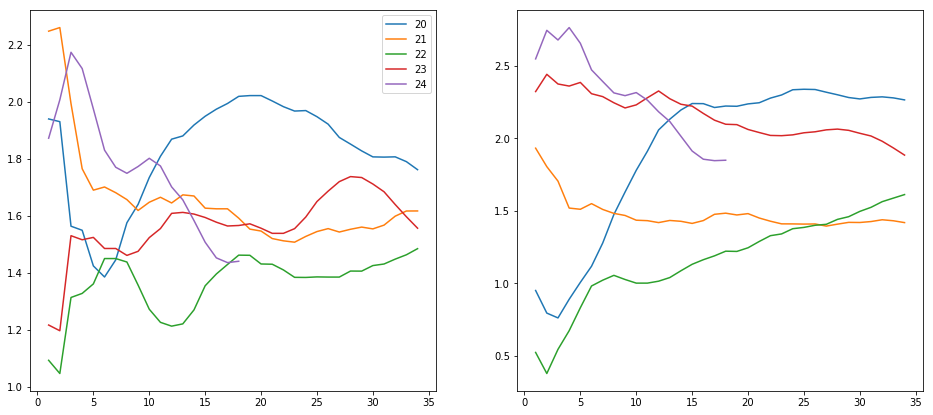

In [5]:
seasons_to_plot = 5

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,7])

for season in range(df['season_number'].max()+1 - seasons_to_plot, df['season_number'].max()+1):
    season_df = df[df['season_number'] == season]   
    axs[0].plot(season_df['pl_gameweek'], season_df['PPG'].rolling(5).mean(), label=season)
    axs[1].plot(season_df['pl_gameweek'], season_df['GFPG'].rolling(5).mean(), label=season)
    
axs[0].legend()
plt.show()

### Drop data that we can't use in training

In [6]:
# Only interested in the Premier League for now
df = df[df['competition'] == 'Premier League']
df.drop('competition', axis=1, inplace=True)

In [7]:
# Scores can't be used in prediction
df.drop(['liverpool_goals_scored', 'opposition_goals_scored'], axis=1, inplace=True)

In [8]:
# Drop any other features we don't want to use in training
df.drop(['season_number', 'season_points'], axis=1, inplace=True)

### Correlation of features with label

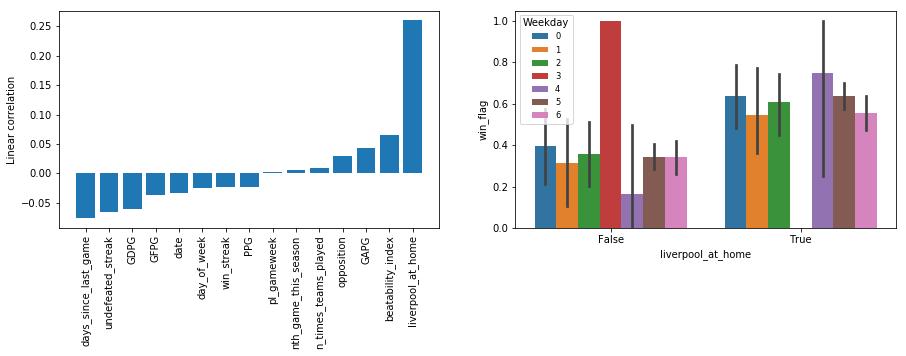

In [9]:
# Calculate correlation matrix then extract the correlations with respect to the win flag
corr_mat = df.corr()
correlation_with_win = corr_mat['win_flag']
correlation_with_win = correlation_with_win[~np.isin(correlation_with_win.index.values, 
                                                     ['win_flag', 'result', 'loss_flag'])]
correlation_with_win.sort_values(inplace=True)

# Plot these correlations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,4])
ax[0].bar(np.arange(len(correlation_with_win)), correlation_with_win)
ax[0].set_xticks(np.arange(len(correlation_with_win)))
ax[0].set_xticklabels(correlation_with_win.index.values, rotation=90)
ax[0].set_ylabel('Linear correlation')

# Plot a bar chart to see how home advantage and day of week affect the win rate
sns.barplot(data=df, x='liverpool_at_home', y='win_flag', hue='day_of_week', ax=ax[1])
ax[1].legend(loc=2, title='Weekday', fontsize='small')
plt.show()

So home advantage has the strongest linear relationship by a way, and appears to be most important on Fridays! (`weekday = 4`)

### Effect of win/undefeated streaks

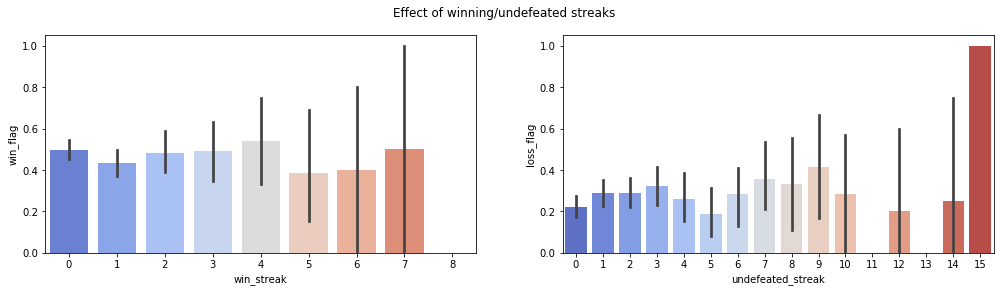

In [10]:
# Plot the streaks
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[17,4])
sns.barplot(data=df, x='win_streak', y='win_flag', ax=ax[0], palette='coolwarm')
sns.barplot(data=df, x='undefeated_streak', y='loss_flag', ax=ax[1], palette='coolwarm')
plt.suptitle('Effect of winning/undefeated streaks')
plt.show()

In [11]:
# Also drop the win_flag after its been used for visualsiation
df.drop(['win_flag', 'loss_flag'], axis=1, inplace=True)

## Dimensionality reduction

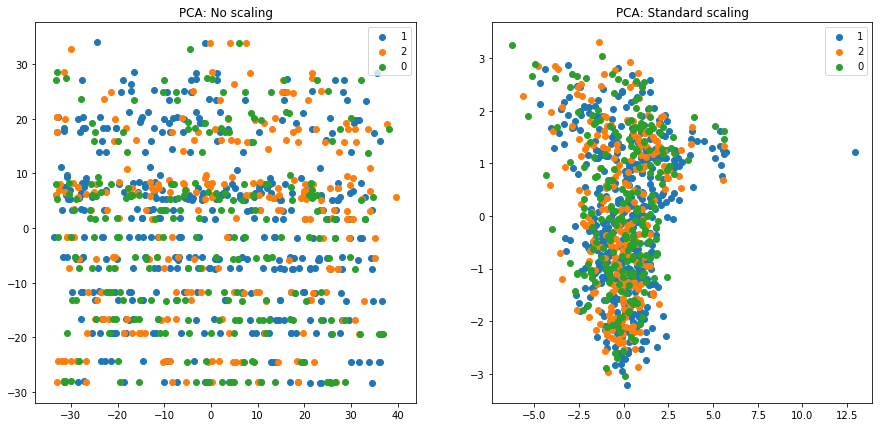

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA without scaling
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.fillna(0))

# PCA with scaled variables
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))
pca_sc = PCA(n_components=2)
scaled_pca = pca_sc.fit_transform(scaled_df)

# Plot the new datasets, colouring by result
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=[15,7])

for result in df['result'].unique():
    result_mask = df['result'] == result
    ax0.scatter(X_pca[result_mask, 0], X_pca[result_mask, 1], label=result)
    
for result in df['result'].unique():
    result_mask = df['result'] == result
    ax1.scatter(scaled_pca[result_mask, 0], scaled_pca[result_mask, 1], label=result)
   
ax0.legend()
ax0.set_title('PCA: No scaling')
ax1.legend()
ax1.set_title('PCA: Standard scaling')

plt.show()

So it looks like with the current features, draws are difficult to distinguish from wins (at least when projected to two dimensions).

### Create a stratified test set

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df.reset_index(inplace=True, drop=True)
for train_index, test_index in split.split(df, df['result']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [14]:
sample_comparison = pd.DataFrame({
    'overall': df['result'].value_counts().sort_index() / len(df),
    'stratified': test['result'].value_counts().sort_index() / len(test),
    })
sample_comparison['strat. % error'] = 100 * (sample_comparison['stratified'] - sample_comparison['overall']) \
                                     / sample_comparison['overall']
sample_comparison

,overall,stratified,strat. % error
0,0.251934,0.254144,0.877193
1,0.477348,0.475138,-0.462963
2,0.270718,0.270718,0.000000


In [15]:
# Separate the labels
y_train = train.pop('result')
y_test = test.pop('result')

# Drop dates, but keep the training dates as a weight
train_weight = train.pop('date')
test.drop('date', axis=1, inplace=True)

### Build a model

In [16]:
import lightgbm as lgbm

# Create a training set
categoricals = ['opposition', 'liverpool_at_home', 'day_of_week']
lgbm_train_set = lgbm.Dataset(data=train, label=y_train, 
                              categorical_feature=categoricals, 
                              weight=train_weight,
                              free_raw_data=False)

# Set the training parameters
lgbm_params = {'application': 'multiclass',
               'booting': 'gbdt',
               'metric': 'multi_logloss',
               'training_metric': True,
               'learning_rate': 0.05,
               'feature_fraction': 0.8,
               'min_data_in_leaf': 30,
               'num_leaves': 31,
               'num_classes': 3}

In [17]:
cv = 1
if cv:
    cv_results = lgbm.cv(train_set=lgbm_train_set, 
                         params=lgbm_params, 
                         nfold=5, 
                         verbose_eval=0, 
                         num_boost_round=100,
                         early_stopping_rounds=10)
    best_iteration = len(cv_results['multi_logloss-mean'])
    print('Mean log loss from best boosting round: {:.4f}'.format(cv_results['multi_logloss-mean'][-1]))

C:\Users\James\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Mean log loss from best boosting round: 1.0107


In [18]:
clf = lgbm.train(train_set=lgbm_train_set, 
                 params=lgbm_params,
                 num_boost_round=best_iteration)

C:\Users\James\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [19]:
y_prob = clf.predict(test, num_iteration=best_iteration)
y_pred = y_prob.argmax(axis=1)

LGBM classification accuracy =  	 46.96%


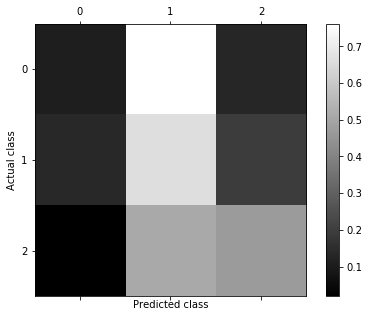

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Simple accuracy score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
print("LGBM classification accuracy =  \t {:.2f}%".format(100*accuracy))

# Visualise the confusion matrix, normalised for classification frequency
conf_matrix = confusion_matrix(y_test, y_pred)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
# np.fill_diagonal(norm_conf_matrix, 0)

fig, ax = plt.subplots(figsize=[7,5])
conf_plot = ax.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.colorbar(ax=ax, mappable=conf_plot)
plt.show()

In [21]:
print(precision)
print(recall)

[0.27777778 0.48717949 0.5       ]
[0.10869565 0.6627907  0.46938776]


Lighter colors represent larger numbers in that position, so in this case we can see a lot of the errors are coming from draws (actual = 0) predicted to be wins (prediction = 1) in the centre-top position.

Second worst are losses predicted to be wins. This strongly indicates that winning predictions are the most wrong.

Sound like Liverpool?!

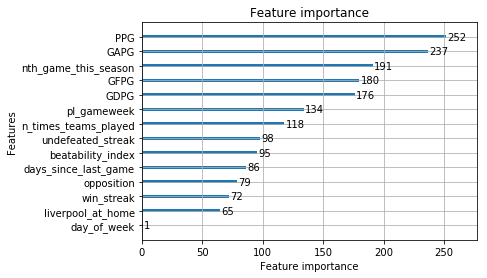

In [22]:
# Save model
clf.save_model(filename=os.path.join('models', 'lgbm_result_classifier.model'))

lgbm.plot_importance(clf)

### Predict a given game

In [35]:
# If data is up to date, this was the data at the time of the most recent game
df.iloc[1, :]

date                    0.998542
nth_game_this_season          31
opposition                    10
liverpool_at_home          False
result                         2
beatability_index       0.166667
day_of_week                    0
days_since_last_game           2
win_streak                     2
undefeated_streak              3
pl_gameweek                   22
PPG                      1.52381
GFPG                     1.95238
GAPG                     1.47619
GDPG                     0.47619
n_times_teams_played           8
Name: 1, dtype: object

In [24]:
# Upcoming game info
pred_game_date = '2018-01-22'
pred_game_opp = 'Swansea City'
liverpool_at_home = False
game_number_this_season = 31
days_since_last_game = 8
curr_win_streak = 4
curr_undefeated_streak = 8
pl_gameweek = 24
curr_PPG = 2
curr_GFPG = df.loc[0, 'GFPG']
curr_GAPG = df.loc[0, 'GAPG']
curr_GDPG = df.loc[0, 'GDPG']

In [25]:
given_opp = processor.opposition_encoder.transform([pred_game_opp])
given_opp[0]

39

In [26]:
given_opp_times_played = processor.opposition_count_dict[given_opp[0]]
given_opp_times_played

13

In [27]:
pred_perf_metric = \
    processor.beatability_df.loc[ processor.beatability_df['opposition'] == pred_game_opp, 'beatability_index'].values
pred_perf_metric[0]

0.3

In [28]:
pred_game = np.array([
    game_number_this_season,
    given_opp[0],
    liverpool_at_home,
    pred_perf_metric[0],
    pd.to_datetime(pred_game_date, format='%Y-%m-%d').weekday(),
    days_since_last_game,
    curr_win_streak,
    curr_undefeated_streak,
    given_opp_times_played,
    pl_gameweek,
    curr_PPG,
    curr_GFPG,
    curr_GAPG,
    curr_GDPG
], dtype='O').reshape([1, len(train.columns)])

In [29]:
y_prob_live = clf.predict(pred_game)
y_pred_live = y_prob_live.argmax(axis=1)

In [30]:
if liverpool_at_home:
    home_flag = 'H'
else:
    home_flag = 'A'
print('| {}: {} ({})| {:.2f} | {:.2f} | {:.2f} |  |  |  | '.format(pred_game_date, pred_game_opp, home_flag, 
                                                                   100*y_prob_live[0][1], 100*y_prob_live[0][0], 
                                                                   100*y_prob_live[0][2]))

| 2018-01-22: Swansea City (A)| 32.00 | 25.51 | 42.49 |  |  |  | 


In [31]:
print('Win probability: \t {:.2f}%'.format(100*y_prob_live[0][1]))
print('Loss probability: \t {:.2f}%'.format(100*y_prob_live[0][2]))
print('Draw probability: \t {:.2f}%'.format(100*y_prob_live[0][0]))

Win probability: 	 32.00%
Loss probability: 	 42.49%
Draw probability: 	 25.51%


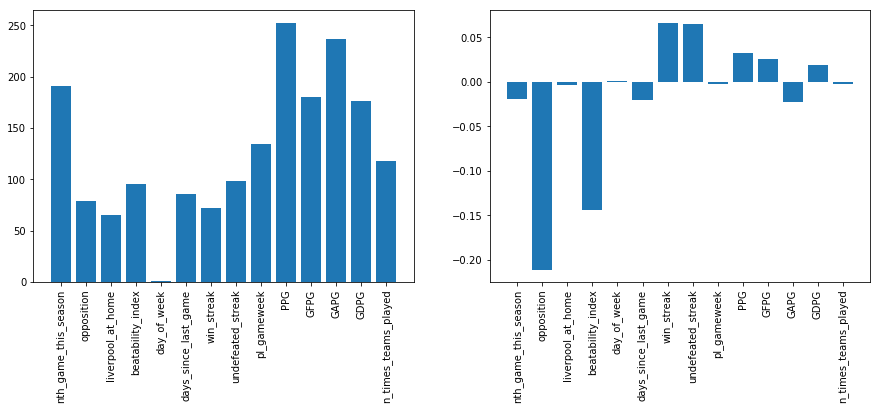

In [32]:
feature_contributions = clf.predict(pred_game, pred_contrib=True)
ind = np.arange(len(clf.feature_importance()))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax[0].bar(ind, clf.feature_importance())
ax[1].bar(ind, feature_contributions.ravel()[:-1])
for axs in ax:
    axs.set_xticks(np.arange(len(clf.feature_importance())))
    axs.set_xticklabels(clf.feature_name(), rotation=90)
plt.show()

In [33]:
# Calculate log loss of prediction given actual result
from sklearn.metrics import log_loss

y_actual_live = np.array([[0, 1, 0]]) 
log_loss(y_actual_live, y_prob_live)

1.1393080574522827